# <ins> 5minsNIMROD_vs_RainGauge</ins>

Does NIMROD produce a similar set of AMAX producing events as are found in the rain gauge data?



In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import os
import sys
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt    
import re
import pickle
import matplotlib.patches as mpatches
from statsmodels.graphics.mosaicplot import mosaic
from tabulate import tabulate

sys.path.insert(1, '../')
from Prepare_Events_Functions import *
from Plot_events_functions import *

In [6]:
color_mapping = {
    'F2': (0.0, 0.0, 1.0, 0.6),    # darkblue with 0.6 alpha
    'F1': (0.0, 0.6902, 1.0, 0.6), # deepskyblue with 0.6 alpha
    'C': (0.5, 0.5, 0.5, 0.6),     # grey with 0.6 alpha
    'B1': (0.8039, 0.0, 0.0, 0.6), # indianred with 0.6 alpha
    'B2': (0.5451, 0.0, 0.0, 0.6)}  # darkred with 0.6 alpha

color_mapping_seasons = {
    'Summer': (1.0, 0.6471, 0.0, 0.6), # orange with 0.6 alpha
    'Winter': (0.0, 0.0, 1.0, 0.6)}     # blue with 0.6 alpha}

quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
quintile_cats_loading = ['F2','F1', 'C', 'B1', 'B2']
n= 5
quintile_cats_season = ['Winter', 'Summer']    

### Read in rain gauge data

In [16]:
rvh_profiles = pd.read_csv("../../../CatchmentAnalysis/CreateSyntheticRainfallEvents/ObservedProfiles/kmeans_15clustersPerDur.csv")
# # Just keep prain (proportion of rainfall in each timestep)
rvh_profiles = rvh_profiles[rvh_profiles['Variable'] == 'irain']
rvh_profiles = rvh_profiles[rvh_profiles['Duration'] == '[2:10 - 6:45) hr']
rvh_profiles

,Cluster,Dur_bins,Variable,Mean,Duration,Profile_shape,Cluster_id
1262,1,0.041667,irain,6.544039,[2:10 - 6:45) hr,F2,1-B
1265,1,0.125000,irain,3.001461,[2:10 - 6:45) hr,F2,1-B
1268,1,0.208333,irain,0.645281,[2:10 - 6:45) hr,F2,1-B
1271,1,0.291667,irain,0.282471,[2:10 - 6:45) hr,F2,1-B
1274,1,0.375000,irain,0.192840,[2:10 - 6:45) hr,F2,1-B
...,...,...,...,...,...,...,...
1877,11,1.000000,irain,0.000000,[2:10 - 6:45) hr,F1,11-B
1880,12,1.000000,irain,0.000000,[2:10 - 6:45) hr,B1,12-B
1883,13,1.000000,irain,0.000000,[2:10 - 6:45) hr,C,13-B
1886,14,1.000000,irain,0.000000,[2:10 - 6:45) hr,B1,14-B


## Prepare the data
Read in dataframe containing the raw and processed rainfall data, alongside the categorisations

In [22]:
with open(f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/NIMROD_5mins/WholeYear/1km_filtered_100/df_nonulls.pkl", 'rb') as f:
    nimrod = pickle.load(f)  

In [19]:
order_duration = ['0.25-2.10 hr', '2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']

nimrod['DurationRange_notpersonalised'] = pd.Categorical(nimrod["DurationRange_notpersonalised"], categories=order_duration, 
                                                      ordered=True)

Split the data in different ways

In [27]:
nimrod_shortdurations = nimrod[nimrod["duration"]<6]
nimrod_longdurations = nimrod[nimrod["duration"]>=6]
nimrod_shortdurations_divisibleby5 = nimrod_shortdurations[nimrod_shortdurations['precip'].apply(is_multiple_of_5)]
nimrod_longdurations_divisibleby5 = nimrod_longdurations[nimrod_longdurations['precip'].apply(is_multiple_of_5)]
nimrod_summer =nimrod[nimrod["season"]=='Summer']
nimrod_winter =nimrod[nimrod["season"]=='Winter']

In [28]:
print(f"There are {len(nimrod)} NIMROD files")

There are 76568 NIMROD files


### Check the split of AMAX producing events between summer and winter
For each year

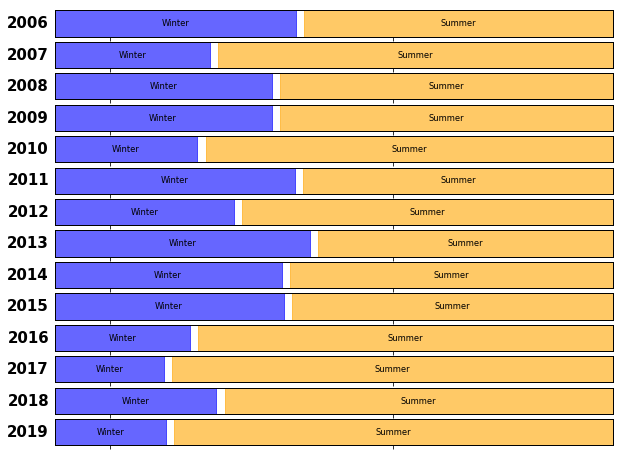

In [11]:
fig, axs = plt.subplots(nrows=14, ncols =1, figsize=(10, 8), sharex=True)
for number, year in enumerate(range(2006,2020)):
    trimmed = nimrod[nimrod['Year'] == year]
    create_single_variable_mosaic_plot(axs[number], trimmed, 'season', quintile_cats_season, color_mapping_seasons, year, False) 

For events with different characteristics

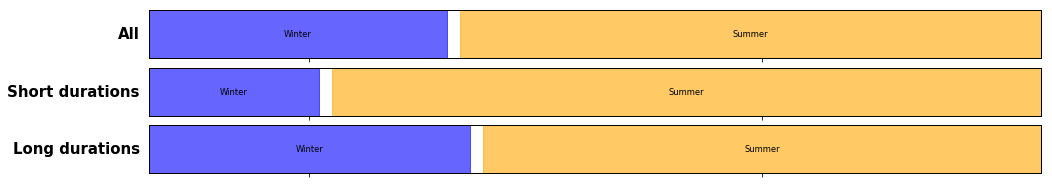

In [9]:
fig, axs = plt.subplots(nrows=3, figsize=(16, 3), sharex=True)  # Adjusted figure size
create_single_variable_mosaic_plot(axs[0], nimrod, 'season', quintile_cats_season, color_mapping_seasons, 'All', False)
create_single_variable_mosaic_plot(axs[1], nimrod_shortdurations, 'season', quintile_cats_season, color_mapping_seasons, 'Short durations', False)
create_single_variable_mosaic_plot(axs[2], nimrod_longdurations, 'season', quintile_cats_season, color_mapping_seasons, 'Long durations', False)

For events in different duration bins

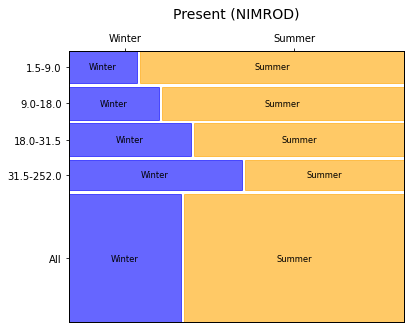

In [10]:
fig, ax = plt.subplots(ncols=1, figsize=(6,5))
create_mosaic_plot(ax,nimrod , cross_variable1 = 'DurationRange_personalised', cross_variable2='season', quintile_cats= quintile_cats_season, include_all= True, filter_events=True)
ax.set_title('Present (NIMROD)', fontsize=14, y=1.1);

## Analysis of ways of classifying loading
Choosing only events with a number of data points divisible by 5 the number of events in front loaded categories decreases and the number of events in back loaded categories increases.

### Questions:
- Does normalising the data make a difference to the profile classification?
    - Compare for raw rain, and the interpolated profiles
- Classifying based on the raw data, rather than interpolated profiles, does it make a difference if we just consider profiles of a length divisible by 5?
- Do we get similar results using raw data, for just events divisible by 5, as we do for profiles interpolated to length 15?
    - Can we also check a comparison between events divisible by 5 and those not divisible by 5, for the interpolated profiles
- How different are the results for profiles interpolated to length 12 and length 15?

In [12]:
create_contingency_table(nimrod, "DurationRange_personalised", quintile_cats_loading, "Loading_profile_norm_12")

Proportional Contingency Table with 'All' Row:
+------------------+------+------+------+------+-----+
| DurationCategory |  F2  |  F1  |  C   |  B1  | B2  |
+------------------+------+------+------+------+-----+
|     1.5-9.0      | 27.1 | 38.6 | 14.5 | 12.3 | 7.5 |
|     9.0-18.0     | 26.8 | 35.5 | 14.0 | 13.8 | 9.9 |
|    18.0-31.5     | 21.2 | 39.7 | 16.2 | 14.3 | 8.6 |
|    31.5-252.0    | 11.1 | 43.3 | 18.5 | 17.8 | 9.3 |
|       All        | 21.7 | 39.2 | 15.8 | 14.5 | 8.8 |
+------------------+------+------+------+------+-----+


In [13]:
create_contingency_table(nimrod_shortdurations, "DurationRange_personalised", quintile_cats_loading, "Loading_profile_norm_12")

Proportional Contingency Table with 'All' Row:
+------------------+------+------+------+------+-----+
| DurationCategory |  F2  |  F1  |  C   |  B1  | B2  |
+------------------+------+------+------+------+-----+
|     1.5-9.0      | 27.2 | 40.6 | 14.3 | 11.4 | 6.4 |
|       All        | 27.2 | 40.6 | 14.3 | 11.4 | 6.4 |
+------------------+------+------+------+------+-----+


In [74]:
    
def create_single_variable_mosaic_plot_pctlabels(ax, data, split_variable, order, color_mapping, title):
           
    # Count the occurrences and reshape for mosaic plot
    count_data = data[split_variable].value_counts().reindex(order, fill_value=0)
    
    # Convert to dictionary format suitable for mosaic plot
    mosaic_data = count_data.to_dict()
    
    # Function to specify properties including colors based on cross_variable
    def props(key):
        # Extract category from key if it's a tuple
        if isinstance(key, tuple):
            category = key[0]  # Extract the first element from the tuple
        else:
            category = key  # Use directly if it's not a tuple
        color = color_mapping.get(category, (0.0, 0.0, 0.0, 0.6))  # Default to black if not found
        return {'color': color}
    
    # Calculate total number of occurrences for percentage calculation
    total_count = count_data.sum()
    
    # Plot the mosaic plot with automatic labels
    labelizer = lambda key: ''
    fig, rects = mosaic(mosaic_data, title='', labelizer = labelizer, properties=props, ax=ax, gap=0.015, horizontal=True)
    ax.invert_yaxis()  # Optional: Invert y-axis to match standard bar plot orientation
    ax.set_xticklabels([])  # Remove x-axis labels
    
    the_ls = range(0,len(order))
    if split_variable == 'Loading_profile_molly': 
        the_ls = [the_ls[0]] + [x * 6 for x in the_ls[1:]]
    else:
        the_ls = [the_ls[0]] + [x * 4 for x in the_ls[1:]]

    # Manually replace the labels with percentage labels
    counter=0
    for key, (x1, y1, x2, y2) in rects.items():
        count = mosaic_data[key[0]]
        percentage = (count / total_count) * 100
        label = f'{percentage:.2f}%'
        
        # Find the label at this position and replace its text
        for text in ax.texts:
            if counter in the_ls:
                text.set_text(label)
                text.set_fontsize(10)
                text.set_color('black')
            counter=counter+1
            
    for key, (x1, y1, x2, y2) in rects.items():
        if x1 == 0:  # Check if this is the leftmost bar
            ax.text(x1-0.01, (y1 + y2) / 2, title, va='center', ha='right', fontsize=15, color='black', weight='bold')  

In [75]:
def create_single_variable_mosaic_plot_pctlabels_rvh(ax, data, split_variable, order, color_mapping, title):
           
    # Count the occurrences and reshape for mosaic plot
    count_data = data['Loading_profile_molly']
    
    # Convert to dictionary format suitable for mosaic plot
    mosaic_data = count_data.to_dict()
    
    # Function to specify properties including colors based on cross_variable
    def props(key):
        # Extract category from key if it's a tuple
        if isinstance(key, tuple):
            category = key[0]  # Extract the first element from the tuple
        else:
            category = key  # Use directly if it's not a tuple
        color = color_mapping.get(category, (0.0, 0.0, 0.0, 0.6))  # Default to black if not found
        return {'color': color}
    
    # Calculate total number of occurrences for percentage calculation
    total_count = count_data.sum()
    
    # Plot the mosaic plot with automatic labels
    labelizer = lambda key: ''
    fig, rects = mosaic(mosaic_data, title='', labelizer = labelizer, properties=props, ax=ax, gap=0.015, horizontal=True)
    ax.invert_yaxis()  # Optional: Invert y-axis to match standard bar plot orientation
    ax.set_xticklabels([])  # Remove x-axis labels
    
    the_ls = range(0,len(order))
    if split_variable == 'Loading_profile_molly': 
        the_ls = [the_ls[0]] + [x * 6 for x in the_ls[1:]]
    else:
        the_ls = [the_ls[0]] + [x * 4 for x in the_ls[1:]]

    # Manually replace the labels with percentage labels
    counter=0
    for key, (x1, y1, x2, y2) in rects.items():
        count = mosaic_data[key[0]]
        percentage = (count / total_count) * 100
        label = f'{percentage:.2f}%'
        
        # Find the label at this position and replace its text
        for text in ax.texts:
            if counter in the_ls:
                text.set_text(label)
                text.set_fontsize(10)
                text.set_color('black')
            counter=counter+1
            
    for key, (x1, y1, x2, y2) in rects.items():
        if x1 == 0:  # Check if this is the leftmost bar
            ax.text(x1-0.01, (y1 + y2) / 2, title, va='center', ha='right', fontsize=15, color='black', weight='bold')  

In [72]:
rvh = pd.DataFrame({'F2':20.6, 'F1':21.6, 'C':22.0, 'B1':20.8, 'B2':14.9},index=['Loading_profile_molly']).T

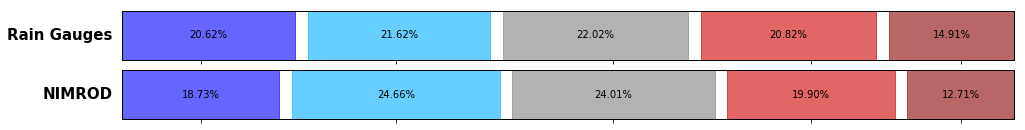

In [78]:
# Desired order of loading categories
fig, axs = plt.subplots(nrows =2, figsize=(16,2), sharex=True)
create_single_variable_mosaic_plot_pctlabels_rvh(axs[0], rvh, 'Loading_profile_molly',quintile_cats_loading, color_mapping, 'Rain Gauges')
create_single_variable_mosaic_plot_pctlabels(axs[1], nimrod, 'Loading_profile_molly',quintile_cats_loading, color_mapping, 'NIMROD')

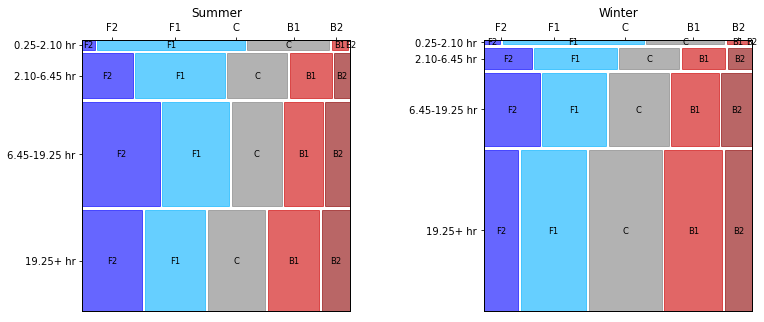

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
fig.subplots_adjust(wspace=0.5)
create_mosaic_plot(axs[0],nimrod_summer , cross_variable1 = 'DurationRange_notpersonalised', cross_variable2='Loading_profile_raw_rain',
                   quintile_cats= quintile_cats_loading, title='Summer', include_all= False, filter_events=True)
create_mosaic_plot(axs[1],nimrod_winter , cross_variable1 = 'DurationRange_notpersonalised', cross_variable2='Loading_profile_raw_rain', 
                   quintile_cats= quintile_cats_loading, title='Winter', include_all= False, filter_events=True)

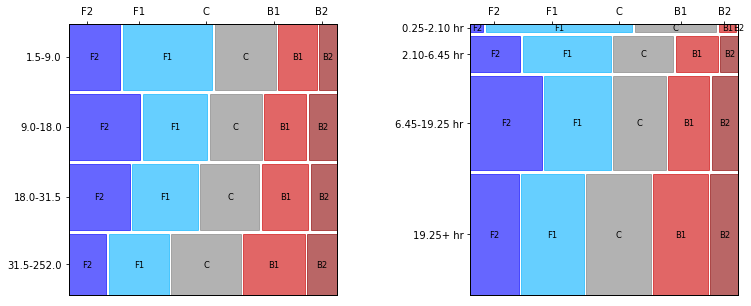

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
fig.subplots_adjust(wspace=0.5)
create_mosaic_plot(axs[0],nimrod , cross_variable1 = 'DurationRange_personalised', cross_variable2='Loading_profile_raw_rain', quintile_cats= quintile_cats_loading, include_all= False, filter_events=True)
create_mosaic_plot(axs[1],nimrod , cross_variable1 = 'DurationRange_notpersonalised', cross_variable2='Loading_profile_raw_rain', quintile_cats= quintile_cats_loading, include_all= False, filter_events=True)

## Summary profiles

In [79]:
duration_bin_1 =nimrod[nimrod["DurationRange_notpersonalised"]=='0.25-2.10 hr']
duration_bin_2 =nimrod[nimrod["DurationRange_notpersonalised"]=='2.10-6.45 hr']
duration_bin_3 =nimrod[nimrod["DurationRange_notpersonalised"]=='6.45-19.25 hr']
duration_bin_4 =nimrod[nimrod["DurationRange_notpersonalised"]=='19.25+ hr']

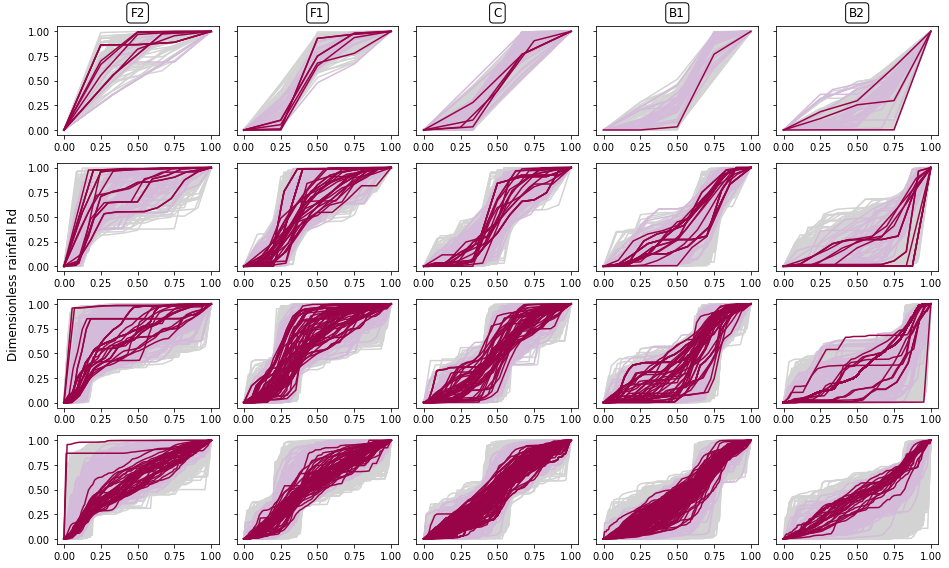

In [80]:
# Prepare the subplots
fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(13, 8), sharey=True)

# Plot df in the first row and df2 in the second row
plot_profiles_by_percentile(axs[0, :], duration_bin_1)  # First row
plot_profiles_by_percentile(axs[1, :], duration_bin_2)  # Second row
plot_profiles_by_percentile(axs[2, :], duration_bin_3)  # First row
plot_profiles_by_percentile(axs[3, :], duration_bin_4)  # Second row

# Add column labels with boxes
column_labels = ['F2', 'F1', 'C', 'B1', 'B2']
for ax, label in zip(axs[0, :], column_labels):
    ax.set_title(label, pad=10, bbox={'facecolor': 'white', 'edgecolor': 'black', 'boxstyle': 'round,pad=0.3'})

# Adjust layout and display the figure
fig.tight_layout()
fig.supylabel('Dimensionless rainfall Rd', x=-0.01)
plt.show()